In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from utils import  amplitude_scaling, load_dataset, save_distance_matrix


In [2]:
X_train, y_train, X_test, y_test, enc_dict = load_dataset('../dataset_ts/ts_data_paa128.npz', squeeze=True)

In [3]:
enc_dict

{0: 'emo',
 1: 'folk',
 2: 'goth',
 3: 'happy',
 4: 'heavy-metal',
 5: 'honky-tonk',
 6: 'j-idol',
 7: 'kids',
 8: 'minimal-techno',
 9: 'mpb',
 10: 'new-age',
 11: 'opera',
 12: 'piano',
 13: 'progressive-house',
 14: 'salsa',
 15: 'sertanejo',
 16: 'sleep',
 17: 'songwriter',
 18: 'synth-pop',
 19: 'world-music'}

# Estrazione motif e discord

In [4]:

# divido gli indici per genere

genres_group = [[] for i in range(20)]

# concateno le time series dello stesso genere

for i in range(X_train.shape[0]):
    genre = y_train[i]
    genres_group[genre] += list(X_train[i,:])

# ora ho delle lunghissime time series concatenate, una per genere (la lista genres_gruop conserva l'ordine dei generi, 
# quindi per esempio nell'indice 0 ci sarà la time series del genere 'emo')


In [5]:
from matrixprofile import *
from matrixprofile.discords import discords
import os


def extract_motifs_discords(dataset:list, window:int, max_n:int) -> dict:
    """
    funzione per estrarre il matrix profile, i motif e i discord da un dataset di time series.
    window: parametro che regola la lunghezza dei motif e i discord estratti;
    max_n: parametro che regola il numero di motif e discord estratti; (se max_n è maggiore dei motif o discord effettivamente estraibile dalla time series l'esecuzione potrebbe non andare come previsto).

    Restituisce un dizionario contenente:
        - 'matrix' : matrice (numero_time_series x 2 x max_n x window),
        - 'matrix_profile' : lista di coppie (matrix profile, matrix profile index) per ogni time series del dataset,
        - 'motifs' : lista di coppie (motifs, motifs_dist) per ogni time series del dataset,
        - 'discords' : lista di indici dei discord di ogni time series del dataset.
    """

    # data è una matrice numpy con shape: numero_time_series x 2 x max_n x window; quindi conterrà tutti i motif e i discord di ogni time series 
    data = np.zeros((len(dataset), 2, max_n, window))

    # conterrà le coppie (matrix profile, matrix profile index) per ogni time series del dataset 
    mat_prof_list = []

    # conterrà le coppie (motifs, motifs_dist) per ogni time series del dataset
    motifs_list = []

    # conterrà la lista di indici dei discord di ogni time series del dataset
    discord_list = []

    for j in range(len(dataset)):
        # time series da analizzare
        ts = dataset[j]

        # faccio il matrix profile
        mat_prof, mat_prof_index = matrixProfile.stomp(ts, window)
        
        # estraggo i motif: mots è una lista degli indici di ogni motif, mentre mots_dist sono le rispettive distanze dei motif dalla ts
        mots, mots_dist = motifs.motifs(np.asarray(ts), (mat_prof, mat_prof_index), max_motifs=max_n)

        # estraggo i discord: dist è una lista degli indici dei discord trovati
        dis = discords(mat_prof, ex_zone=5, k=max_n)

        # ora voglio estrarre i motif e i discord come delle piccole time series:
        for i in range(max_n):
            try:
                motif = ts[mots[i][0]:mots[i][0]+window]
            except IndexError:
                break
            discord = ts[dis[i]:dis[i]+window]

            data[j,0,i] = motif
            data[j,1,i] = discord

        mat_prof_list.append((mat_prof, mat_prof_index))
        motifs_list.append((mots, mots_dist))
        discord_list.append(dis)

        

        if j % (len(dataset)/20) == 0:
            print(f'[{"="*int((j+1)/(len(dataset)/20))}{"-"*(20-int((j+1)/(len(dataset)/20)))}]')
    
    return {
        'matrix' : data,
        'matrix_profile' : mat_prof_list,
        'motifs' : motifs_list,
        'discords' : discord
    }


        

        


In [6]:
dict_data = extract_motifs_discords(genres_group, 20, 20)

# data sarà la matrice che mi serve per estrarre le distanze per la classificazione
data = dict_data['matrix']

[=-------------------]
[==------------------]
[===-----------------]
[====----------------]
[=====---------------]
[======--------------]
[=======-------------]


c:\Users\giuli\anaconda3\envs\DEEPL\lib\site-packages\matrixprofile\utils.py:177: RuntimeWarning: divide by zero encountered in divide
  res = 2*m*(1-(dot-m*mean*q_mean)/(m*std*q_std))
c:\Users\giuli\anaconda3\envs\DEEPL\lib\site-packages\matrixprofile\utils.py:177: RuntimeWarning: invalid value encountered in divide
  res = 2*m*(1-(dot-m*mean*q_mean)/(m*std*q_std))
c:\Users\giuli\anaconda3\envs\DEEPL\lib\site-packages\matrixprofile\distanceProfile.py:66: RuntimeWarning: invalid value encountered in sqrt
  distanceProfile = np.real(np.sqrt(mass(query,tsB).astype(complex)))


[========------------]
[=========-----------]
[==========----------]
[===========---------]
[============--------]
[=============-------]
[==============------]
[===============-----]
[================----]
[=================---]
[==================--]
[===================-]
[====================]


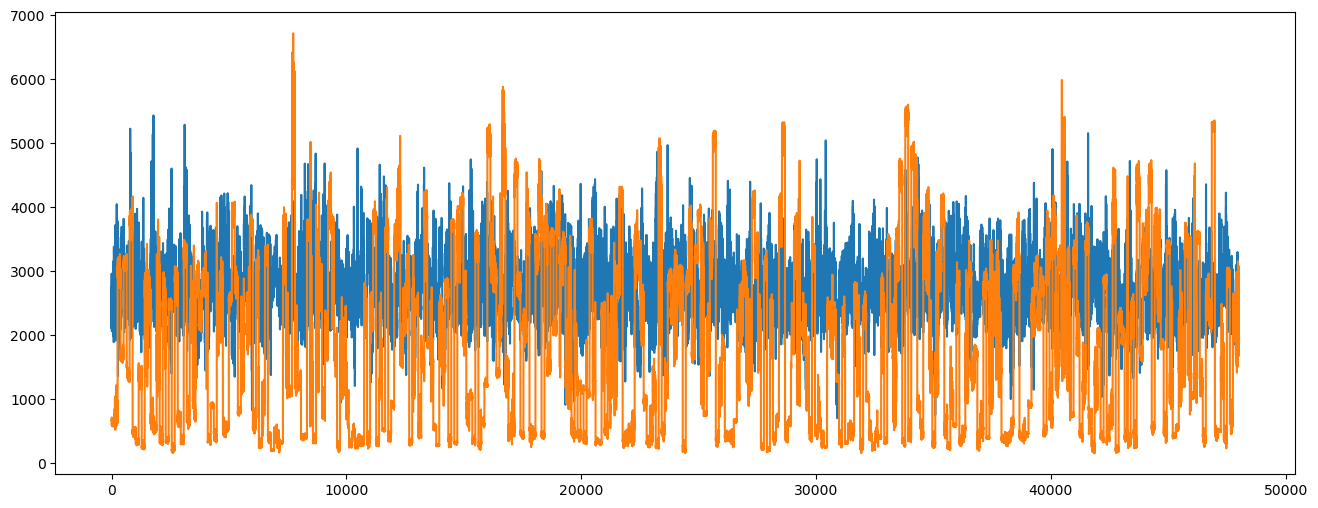

In [7]:
# grafico time series dei generi heavy-metal (4) e sleep (16)
plt.figure(figsize=(16,6))
plt.plot(genres_group[4])
plt.plot(genres_group[16])
plt.show()

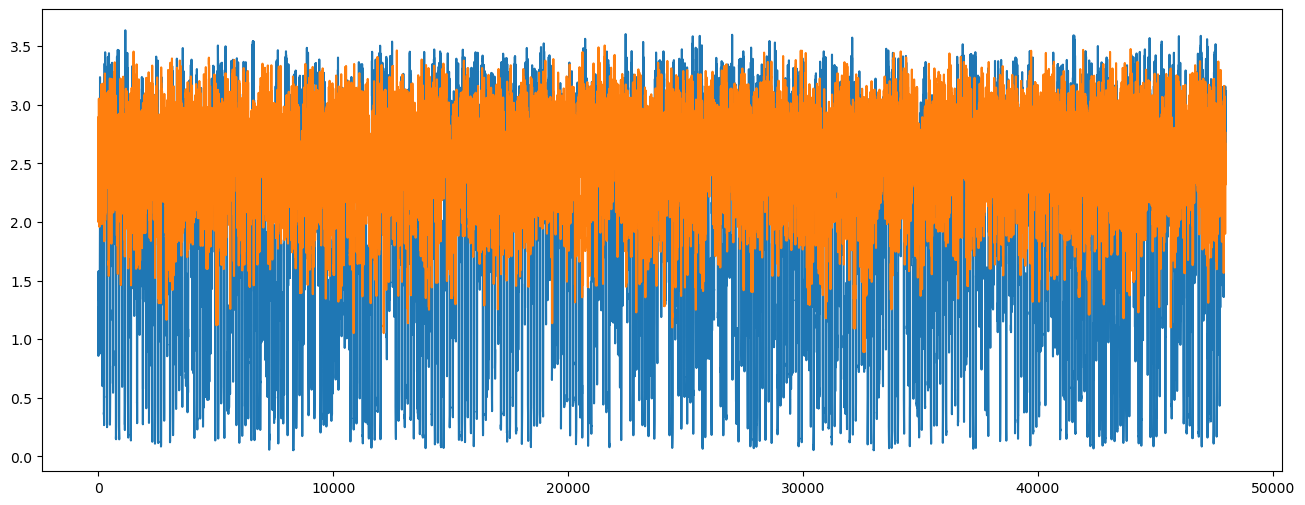

In [8]:
# grafico matrix profile dei generi heavy-metal (4) e sleep (16)
plt.figure(figsize=(16,6))
plt.plot(dict_data['matrix_profile'][16][0])
plt.plot(dict_data['matrix_profile'][4][0])
#plt.plot(genres_group[10])
plt.show()

# Classificazione con distanze dai motifs e i discord

In [17]:
def minimum_distance(time_series, subsequence):
    width = 20
    i = 0
    min_dist = np.inf
    while True:
        try:
            dist = np.linalg.norm(time_series[i:i+width] - subsequence)
        except ValueError:
            break
        if dist < min_dist:
            min_dist = dist
        
        i+=1
    return min_dist


total_dataset = np.concatenate((X_train, X_test), axis=0)


# per ogni time series devo calcolare la distanza di ogni motif dalle time series, prendere le top 5 e fare la media
ts_data = np.zeros((10000,20,2))
for k in range(total_dataset.shape[0]):
    ts = total_dataset[k]
    for genre in range(data.shape[0]): # per ogni genere
        distances = np.zeros((2,20)) # distanze dai motif e dai discord del genere
        for i in range(data.shape[1]): # per motif e discord
            for j in range(data.shape[2]): # per ogni motif o discord
                subseq = data[genre, i, j, :] # il motif/discord
                distances[i,j] = minimum_distance(ts, subseq)
                
        motif_dists = np.sort(distances[0,:])[:5]
        discord_dists = np.sort(distances[1,:])[:5]   

        ts_data[k,genre,0] = np.mean(motif_dists)
        ts_data[k,genre,1] = np.mean(discord_dists)

    if k%100 == 0:
        print(k)



0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900


## I dataset

In [18]:
X_motif = ts_data[:,:,0]
X_train_motif = X_motif[:7500]
X_test_motif = X_motif[7500:]

X_discord = ts_data[:,:,1]
X_train_discord = X_discord[:7500]
X_test_discord = X_discord[7500:]

X_tot = np.concatenate((ts_data[:,:,0], ts_data[:,:,1]), axis=1)
X_train_tot = X_tot[:7500]
X_test_tot = X_tot[7500:]


## Model Selection

In [19]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    make_scorer
)
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall

### Motifs:

KNN:

In [20]:
# knn
scaler = MinMaxScaler()
scaler.fit(X_train_motif)
X_train_motif_scaled = scaler.transform(X_train_motif)
X_test_motif_scaled = scaler.transform(X_test_motif)


parameters = {'n_neighbors': [1,5,10,15,20,30,40,50,60,80,100,125,150,200],
              'weights': ['distance', 'uniform'],
              'metric': ['euclidean', 'cosine', 'manhattan'],
              'n_jobs': [-1]
              }
knn = KNeighborsClassifier()
clf = GridSearchCV(
    knn, 
    parameters, 
    scoring='accuracy', 
    n_jobs=-1,
    refit=True,
    )
clf.fit(X_train_motif_scaled, y_train)
print(clf.best_estimator_)
print(clf.best_params_)
print(clf.best_score_)


KNeighborsClassifier(metric='cosine', n_jobs=-1, n_neighbors=80,
                     weights='distance')
{'metric': 'cosine', 'n_jobs': -1, 'n_neighbors': 80, 'weights': 'distance'}
0.2945333333333333


In [21]:
def decode_y(y_enc, enc_dict):
    return [enc_dict[y] for y in y_enc]

def top_flop_f1(y_true, y_pred):
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    l = [(key, val['f1-score']) for key,val in report.items() if (isinstance(val, dict) and key not in ['macro avg', 'weighted avg'])]
    l.sort(key= lambda x: x[1], reverse=True)
    top5 = l[:5]
    l.sort(key= lambda x: x[1], reverse=False)
    flop5 = l[:5]

    print('TOP 5 F1-SCORE:')
    for top in top5:
        print(f'{top[0]}: {top[1]}')

    print('\n\nFLOP 5 F1-SCORE:')
    for flop in flop5:
        print(f'{flop[0]}: {flop[1]}')



                   precision    recall  f1-score   support

              emo       0.25      0.15      0.19       375
             folk       0.15      0.05      0.07       375
             goth       0.16      0.05      0.08       375
            happy       0.40      0.47      0.43       375
      heavy-metal       0.27      0.51      0.35       375
       honky-tonk       0.23      0.41      0.29       375
           j-idol       0.27      0.31      0.29       375
             kids       0.31      0.31      0.31       375
   minimal-techno       0.69      0.37      0.48       375
              mpb       0.10      0.03      0.04       375
          new-age       0.35      0.49      0.41       375
            opera       0.31      0.30      0.30       375
            piano       0.56      0.46      0.51       375
progressive-house       0.40      0.23      0.29       375
            salsa       0.19      0.35      0.25       375
        sertanejo       0.19      0.49      0.28       

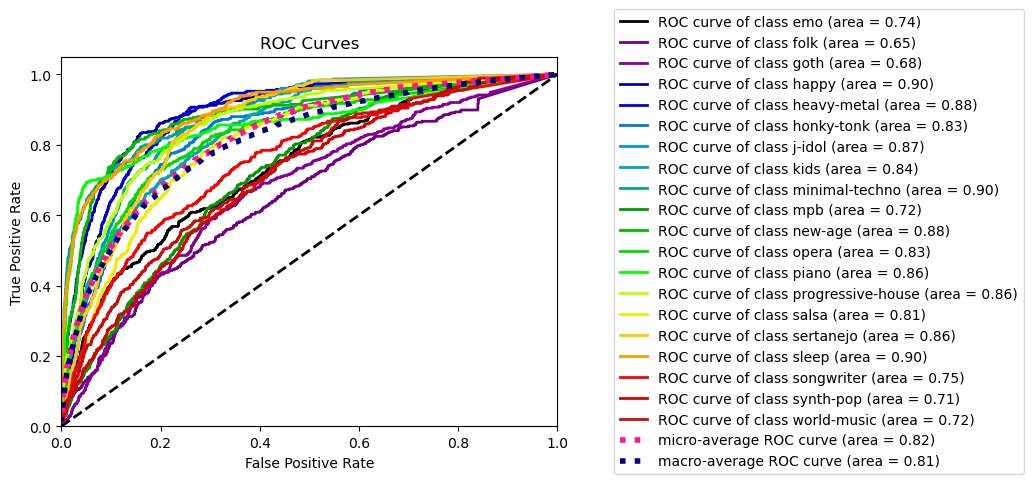

TOP 5 F1-SCORE:
sleep: 0.5171849427168577
piano: 0.5073313782991202
minimal-techno: 0.47735191637630664
happy: 0.4326328800988875
new-age: 0.40707964601769914


FLOP 5 F1-SCORE:
mpb: 0.04201680672268908
folk: 0.07272727272727272
goth: 0.07952286282306163
synth-pop: 0.08597285067873303
world-music: 0.15070643642072212


In [22]:
# knn selected model
model = KNeighborsClassifier(metric='cosine', n_jobs=-1, n_neighbors=80, weights='distance')
y_pred = decode_y(cross_val_predict(model, X_train_motif_scaled, y_train, cv=10), enc_dict)
y_pred_proba = cross_val_predict(model, X_train_motif_scaled, y_train, cv=10, method='predict_proba')

print(classification_report(decode_y(y_train, enc_dict), y_pred))
plot_roc(decode_y(y_train, enc_dict), y_pred_proba)
plt.legend(loc='center left',prop={'size': 10}, bbox_to_anchor=(1.1, 0.5))
plt.show()

top_flop_f1(decode_y(y_train, enc_dict), y_pred)

Decision Tree:

In [23]:
# decision tree
parameters = {'criterion': ['entropy'],
              'min_samples_split': [2,4,6,8,10,14,18,24,30,40,50,60,75,100],
              'min_samples_leaf': [1,2,4,6,8,10,14,18,24,30,40,50,60,75,100],
              'max_depth': [4,6,8,10,12,14,16,20,24]
              }
dtc = DecisionTreeClassifier(random_state=8)
clf = GridSearchCV(
    dtc, 
    parameters, 
    scoring='accuracy', 
    n_jobs=-1,
    refit=True,
    verbose=2,
    cv=2
    )
clf.fit(X_train_motif_scaled, y_train)
print(clf.best_estimator_)
print(clf.best_params_)
print(clf.best_score_)

Fitting 2 folds for each of 1890 candidates, totalling 3780 fits
DecisionTreeClassifier(criterion='entropy', max_depth=8, min_samples_split=100,
                       random_state=8)
{'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 100}
0.25533333333333336


                   precision    recall  f1-score   support

              emo       0.23      0.07      0.11       375
             folk       0.12      0.05      0.07       375
             goth       0.12      0.06      0.08       375
            happy       0.35      0.53      0.42       375
      heavy-metal       0.25      0.29      0.27       375
       honky-tonk       0.21      0.34      0.26       375
           j-idol       0.26      0.21      0.23       375
             kids       0.24      0.30      0.27       375
   minimal-techno       0.35      0.40      0.37       375
              mpb       0.13      0.06      0.08       375
          new-age       0.38      0.45      0.41       375
            opera       0.31      0.28      0.29       375
            piano       0.57      0.48      0.52       375
progressive-house       0.23      0.19      0.21       375
            salsa       0.20      0.34      0.26       375
        sertanejo       0.18      0.40      0.25       

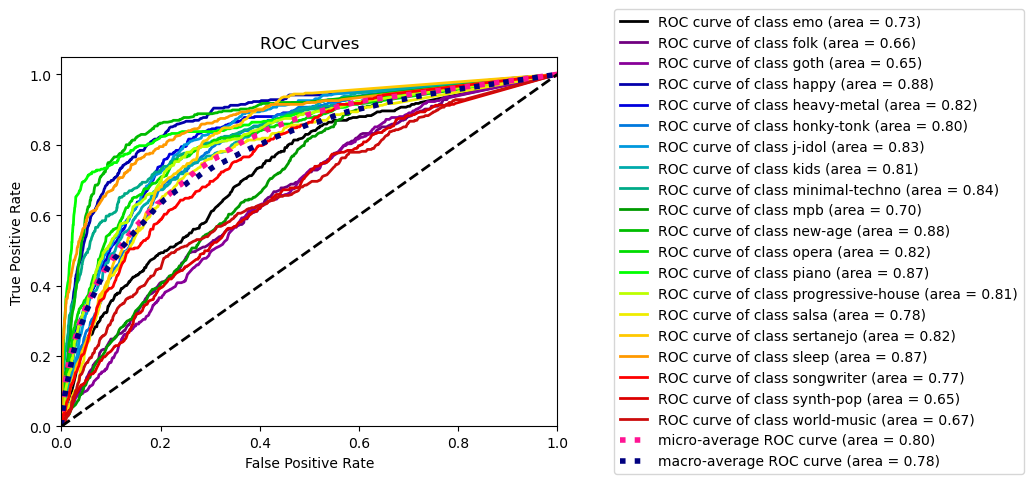

TOP 5 F1-SCORE:
piano: 0.5211062590975255
sleep: 0.4837758112094395
happy: 0.4204909284951974
new-age: 0.40875912408759124
minimal-techno: 0.373134328358209


FLOP 5 F1-SCORE:
folk: 0.06538461538461539
synth-pop: 0.07068607068607069
mpb: 0.07850467289719626
goth: 0.07942238267148015
emo: 0.10633946830265849


In [24]:
# decision tree selected model
model = DecisionTreeClassifier(criterion='entropy', max_depth=8, min_samples_split=100,
                       random_state=8)
y_pred = decode_y(cross_val_predict(model, X_train_motif_scaled, y_train, cv=10), enc_dict)
y_pred_proba = cross_val_predict(model, X_train_motif_scaled, y_train, cv=10, method='predict_proba')

print(classification_report(decode_y(y_train, enc_dict), y_pred))
plot_roc(decode_y(y_train, enc_dict), y_pred_proba)
plt.legend(loc='center left',prop={'size': 10}, bbox_to_anchor=(1.1, 0.5))
plt.show()

top_flop_f1(decode_y(y_train, enc_dict), y_pred)

In [26]:
# feature importance
model = DecisionTreeClassifier(criterion='entropy', max_depth=8, min_samples_split=100,
                       random_state=8)
model.fit(X_train_motif_scaled, y_train)

importances = model.feature_importances_
indices = decode_y(np.argsort(importances), enc_dict)
indices

['mpb',
 'piano',
 'world-music',
 'goth',
 'sleep',
 'honky-tonk',
 'synth-pop',
 'j-idol',
 'emo',
 'salsa',
 'folk',
 'heavy-metal',
 'kids',
 'opera',
 'sertanejo',
 'songwriter',
 'progressive-house',
 'happy',
 'minimal-techno',
 'new-age']

### Discords:

KNN:

In [27]:
# knn
scaler = MinMaxScaler()
scaler.fit(X_train_discord)
X_train_discord_scaled = scaler.transform(X_train_discord)
X_test_discord_scaled = scaler.transform(X_test_discord)


parameters = {'n_neighbors': [1,5,10,15,20,30,40,50,60,80,100,125,150,200],
              'weights': ['distance', 'uniform'],
              'metric': ['euclidean', 'cosine', 'manhattan'],
              'n_jobs': [-1]
              }
knn = KNeighborsClassifier()
clf = GridSearchCV(
    knn, 
    parameters, 
    scoring='accuracy', 
    n_jobs=-1,
    refit=True,
    )
clf.fit(X_train_discord_scaled, y_train)
print(clf.best_estimator_)
print(clf.best_params_)
print(clf.best_score_)

KNeighborsClassifier(metric='cosine', n_jobs=-1, n_neighbors=60,
                     weights='distance')
{'metric': 'cosine', 'n_jobs': -1, 'n_neighbors': 60, 'weights': 'distance'}
0.25906666666666667


                   precision    recall  f1-score   support

              emo       0.23      0.14      0.18       375
             folk       0.18      0.07      0.11       375
             goth       0.13      0.06      0.08       375
            happy       0.35      0.37      0.36       375
      heavy-metal       0.24      0.43      0.31       375
       honky-tonk       0.22      0.38      0.28       375
           j-idol       0.27      0.41      0.32       375
             kids       0.25      0.34      0.29       375
   minimal-techno       0.26      0.05      0.08       375
              mpb       0.14      0.06      0.09       375
          new-age       0.38      0.45      0.41       375
            opera       0.28      0.31      0.29       375
            piano       0.52      0.46      0.48       375
progressive-house       0.44      0.17      0.24       375
            salsa       0.19      0.34      0.25       375
        sertanejo       0.16      0.38      0.23       

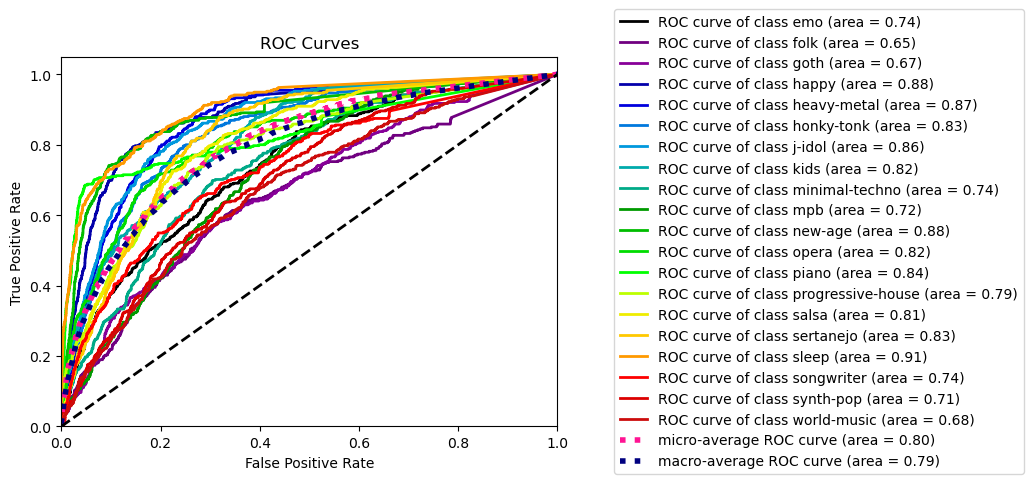

TOP 5 F1-SCORE:
piano: 0.48441926345609065
sleep: 0.4641638225255973
new-age: 0.4097560975609756
happy: 0.36222509702457956
j-idol: 0.32460732984293195


FLOP 5 F1-SCORE:
synth-pop: 0.07755102040816327
goth: 0.07894736842105263
minimal-techno: 0.08108108108108109
mpb: 0.08518518518518518
folk: 0.1050656660412758


In [28]:
# knn selected model
model = KNeighborsClassifier(metric='cosine', n_jobs=-1, n_neighbors=60, weights='distance')
y_pred = decode_y(cross_val_predict(model, X_train_discord_scaled, y_train, cv=10), enc_dict)
y_pred_proba = cross_val_predict(model, X_train_discord_scaled, y_train, cv=10, method='predict_proba')

print(classification_report(decode_y(y_train, enc_dict), y_pred))
plot_roc(decode_y(y_train, enc_dict), y_pred_proba)
plt.legend(loc='center left',prop={'size': 10}, bbox_to_anchor=(1.1, 0.5))
plt.show()

top_flop_f1(decode_y(y_train, enc_dict), y_pred)

Decision Tree:

In [29]:
# decision tree
parameters = {'criterion': ['entropy'],
              'min_samples_split': [2,4,6,8,10,14,18,24,30,40,50,60,75,100],
              'min_samples_leaf': [1,2,4,6,8,10,14,18,24,30,40,50,60,75,100],
              'max_depth': [4,6,8,10,12,14,16,20,24]
              }
dtc = DecisionTreeClassifier(random_state=8)
clf = GridSearchCV(
    dtc, 
    parameters, 
    scoring='accuracy', 
    n_jobs=-1,
    refit=True,
    verbose=2,
    cv=2
    )
clf.fit(X_train_discord_scaled, y_train)
print(clf.best_estimator_)
print(clf.best_params_)
print(clf.best_score_)

Fitting 2 folds for each of 1890 candidates, totalling 3780 fits
DecisionTreeClassifier(criterion='entropy', max_depth=6, min_samples_leaf=14,
                       min_samples_split=30, random_state=8)
{'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 14, 'min_samples_split': 30}
0.23613333333333333


                   precision    recall  f1-score   support

              emo       0.16      0.02      0.04       375
             folk       0.08      0.01      0.01       375
             goth       0.05      0.01      0.02       375
            happy       0.32      0.37      0.35       375
      heavy-metal       0.21      0.40      0.27       375
       honky-tonk       0.21      0.39      0.28       375
           j-idol       0.23      0.27      0.25       375
             kids       0.21      0.32      0.25       375
   minimal-techno       0.07      0.03      0.04       375
              mpb       0.06      0.01      0.01       375
          new-age       0.41      0.50      0.45       375
            opera       0.28      0.26      0.27       375
            piano       0.58      0.42      0.49       375
progressive-house       0.18      0.14      0.15       375
            salsa       0.17      0.38      0.23       375
        sertanejo       0.16      0.51      0.25       

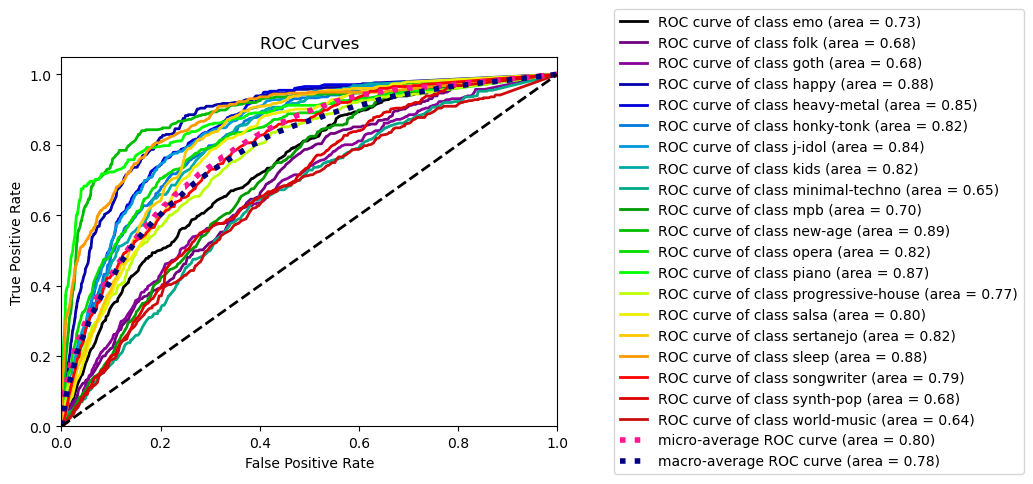

TOP 5 F1-SCORE:
piano: 0.48757763975155277
new-age: 0.4530120481927711
sleep: 0.40610687022900765
happy: 0.34739454094292804
honky-tonk: 0.27735849056603773


FLOP 5 F1-SCORE:
mpb: 0.01405152224824356
folk: 0.014598540145985401
synth-pop: 0.014598540145985401
world-music: 0.014598540145985401
goth: 0.017817371937639197


In [30]:
# decision tree selected model
model = DecisionTreeClassifier(criterion='entropy', max_depth=6, min_samples_leaf=14,
                       min_samples_split=30, random_state=8)
y_pred = decode_y(cross_val_predict(model, X_train_discord_scaled, y_train, cv=10), enc_dict)
y_pred_proba = cross_val_predict(model, X_train_discord_scaled, y_train, cv=10, method='predict_proba')

print(classification_report(decode_y(y_train, enc_dict), y_pred))
plot_roc(decode_y(y_train, enc_dict), y_pred_proba)
plt.legend(loc='center left',prop={'size': 10}, bbox_to_anchor=(1.1, 0.5))
plt.show()

top_flop_f1(decode_y(y_train, enc_dict), y_pred)

In [31]:
# feature importance
model = DecisionTreeClassifier(criterion='entropy', max_depth=6, min_samples_leaf=14,
                       min_samples_split=30, random_state=8)
model.fit(X_train_discord_scaled, y_train)

importances = model.feature_importances_
indices = decode_y(np.argsort(importances), enc_dict)
indices

['songwriter',
 'mpb',
 'folk',
 'emo',
 'synth-pop',
 'honky-tonk',
 'heavy-metal',
 'sertanejo',
 'salsa',
 'world-music',
 'piano',
 'minimal-techno',
 'goth',
 'j-idol',
 'kids',
 'new-age',
 'sleep',
 'opera',
 'progressive-house',
 'happy']

### Total:

KNN:

In [32]:
# knn
scaler = MinMaxScaler()
scaler.fit(X_train_tot)
X_train_tot_scaled = scaler.transform(X_train_tot)
X_test_tot_scaled = scaler.transform(X_test_tot)


parameters = {'n_neighbors': [1,5,10,15,20,30,40,50,60,80,100,125,150,200],
              'weights': ['distance', 'uniform'],
              'metric': ['euclidean', 'cosine', 'manhattan'],
              'n_jobs': [-1]
              }
knn = KNeighborsClassifier()
clf = GridSearchCV(
    knn, 
    parameters, 
    scoring='accuracy', 
    n_jobs=-1,
    refit=True,
    )
clf.fit(X_train_tot_scaled, y_train)
print(clf.best_estimator_)
print(clf.best_params_)
print(clf.best_score_)

KNeighborsClassifier(metric='cosine', n_jobs=-1, n_neighbors=40,
                     weights='distance')
{'metric': 'cosine', 'n_jobs': -1, 'n_neighbors': 40, 'weights': 'distance'}
0.28253333333333336


                   precision    recall  f1-score   support

              emo       0.22      0.14      0.17       375
             folk       0.17      0.09      0.12       375
             goth       0.14      0.06      0.08       375
            happy       0.40      0.40      0.40       375
      heavy-metal       0.25      0.43      0.32       375
       honky-tonk       0.22      0.37      0.28       375
           j-idol       0.26      0.36      0.30       375
             kids       0.27      0.31      0.29       375
   minimal-techno       0.67      0.30      0.42       375
              mpb       0.17      0.09      0.12       375
          new-age       0.38      0.45      0.41       375
            opera       0.29      0.31      0.30       375
            piano       0.54      0.48      0.51       375
progressive-house       0.40      0.19      0.26       375
            salsa       0.19      0.34      0.25       375
        sertanejo       0.20      0.45      0.28       

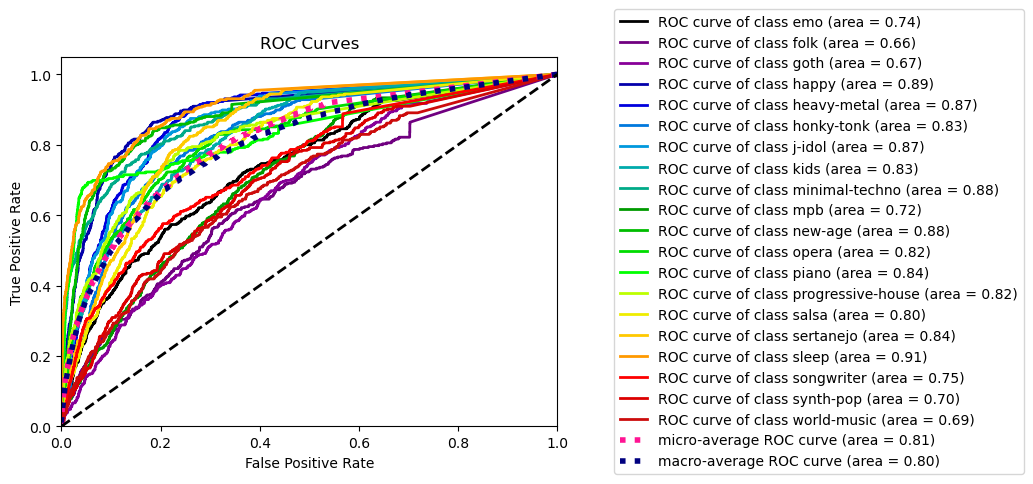

TOP 5 F1-SCORE:
piano: 0.5070422535211268
sleep: 0.4992343032159265
minimal-techno: 0.41911764705882354
new-age: 0.4121212121212121
happy: 0.3989290495314592


FLOP 5 F1-SCORE:
goth: 0.08455882352941177
synth-pop: 0.10150375939849623
folk: 0.11558669001751314
mpb: 0.1168141592920354
world-music: 0.12837837837837837


In [181]:
# knn selected model
model = KNeighborsClassifier(metric='cosine', n_jobs=-1, n_neighbors=40, weights='distance')
y_pred = decode_y(cross_val_predict(model, X_train_tot_scaled, y_train, cv=10), enc_dict)
y_pred_proba = cross_val_predict(model, X_train_tot_scaled, y_train, cv=10, method='predict_proba')

print(classification_report(decode_y(y_train, enc_dict), y_pred))
plot_roc(decode_y(y_train, enc_dict), y_pred_proba)
plt.legend(loc='center left',prop={'size': 10}, bbox_to_anchor=(1.1, 0.5))
plt.show()

top_flop_f1(decode_y(y_train, enc_dict), y_pred)

Decision Tree:

In [69]:
# decision tree
parameters = {'criterion': ['entropy'],
              'min_samples_split': [2,4,6,8,10,14,18,24,30,40,50,60,75,100],
              'min_samples_leaf': [1,2,4,6,8,10,14,18,24,30,40,50,60,75,100],
              'max_depth': [4,6,8,10,12,14,16,20,24]
              }
dtc = DecisionTreeClassifier(random_state=8)
clf = GridSearchCV(
    dtc, 
    parameters, 
    scoring='accuracy', 
    n_jobs=-1,
    refit=True,
    verbose=2,
    cv=2
    )
clf.fit(X_train_tot_scaled, y_train)
print(clf.best_estimator_)
print(clf.best_params_)
print(clf.best_score_)

Fitting 2 folds for each of 1890 candidates, totalling 3780 fits
DecisionTreeClassifier(criterion='entropy', max_depth=6, min_samples_split=40,
                       random_state=8)
{'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 40}
0.25333333333333335


                   precision    recall  f1-score   support

              emo       0.21      0.03      0.06       375
             folk       0.14      0.01      0.02       375
             goth       0.15      0.04      0.06       375
            happy       0.34      0.43      0.38       375
      heavy-metal       0.22      0.38      0.28       375
       honky-tonk       0.20      0.35      0.25       375
           j-idol       0.20      0.17      0.18       375
             kids       0.24      0.39      0.29       375
   minimal-techno       0.44      0.35      0.39       375
              mpb       0.19      0.07      0.10       375
          new-age       0.43      0.43      0.43       375
            opera       0.24      0.25      0.24       375
            piano       0.60      0.50      0.54       375
progressive-house       0.28      0.23      0.25       375
            salsa       0.18      0.42      0.25       375
        sertanejo       0.19      0.37      0.25       

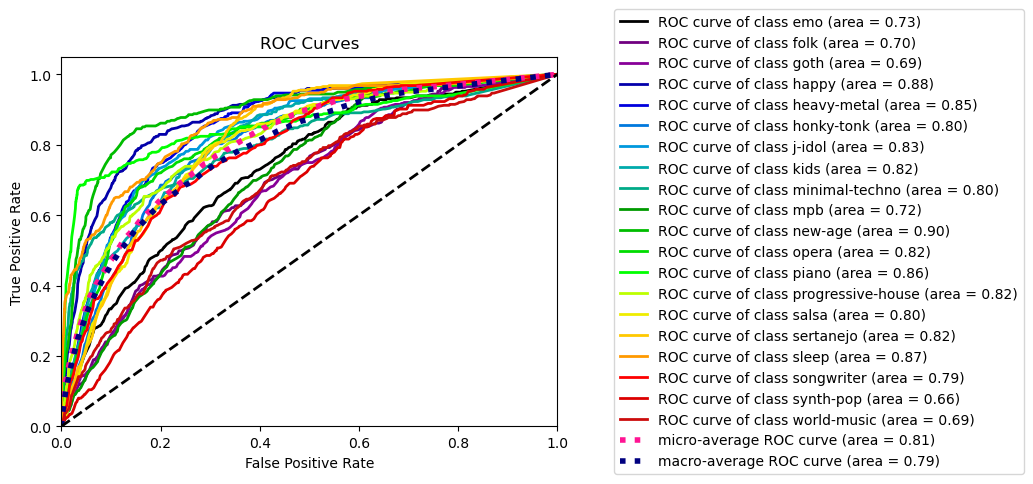

TOP 5 F1-SCORE:
piano: 0.5422740524781341
sleep: 0.4788732394366197
new-age: 0.4266666666666667
minimal-techno: 0.3940740740740741
happy: 0.3806146572104019


FLOP 5 F1-SCORE:
synth-pop: 0.010025062656641603
folk: 0.024390243902439025
emo: 0.0593607305936073
goth: 0.059574468085106386
mpb: 0.10384615384615385


In [182]:
# decision tree selected model
model = DecisionTreeClassifier(criterion='entropy', max_depth=6, min_samples_split=40,
                       random_state=8)
y_pred = decode_y(cross_val_predict(model, X_train_tot_scaled, y_train, cv=10), enc_dict)
y_pred_proba = cross_val_predict(model, X_train_tot_scaled, y_train, cv=10, method='predict_proba')

print(classification_report(decode_y(y_train, enc_dict), y_pred))
plot_roc(decode_y(y_train, enc_dict), y_pred_proba)
plt.legend(loc='center left',prop={'size': 10}, bbox_to_anchor=(1.1, 0.5))
plt.show()

top_flop_f1(decode_y(y_train, enc_dict), y_pred)

## Test

### Motif

KNN:

In [33]:
# knn
knn = KNeighborsClassifier(metric='cosine', n_jobs=-1, n_neighbors=80,
                     weights='distance')
knn.fit(X_train_motif_scaled, y_train)
y_pred = knn.predict(X_test_motif_scaled)
print(classification_report(decode_y(y_test, enc_dict), decode_y(y_pred,enc_dict)))
top_flop_f1(decode_y(y_test, enc_dict), decode_y(y_pred,enc_dict))

                   precision    recall  f1-score   support

              emo       0.29      0.18      0.22       125
             folk       0.10      0.03      0.05       125
             goth       0.17      0.06      0.08       125
            happy       0.37      0.47      0.41       125
      heavy-metal       0.24      0.46      0.32       125
       honky-tonk       0.25      0.46      0.33       125
           j-idol       0.21      0.23      0.22       125
             kids       0.33      0.31      0.32       125
   minimal-techno       0.68      0.40      0.51       125
              mpb       0.14      0.04      0.06       125
          new-age       0.36      0.47      0.41       125
            opera       0.39      0.38      0.39       125
            piano       0.50      0.46      0.48       125
progressive-house       0.41      0.24      0.30       125
            salsa       0.20      0.35      0.25       125
        sertanejo       0.20      0.52      0.29       

Decision Tree

In [34]:
# decision tree
dtc = DecisionTreeClassifier(criterion='entropy', max_depth=8, min_samples_split=100,
                       random_state=8)
dtc.fit(X_train_motif_scaled, y_train)
y_pred = dtc.predict(X_test_motif_scaled)
print(classification_report(decode_y(y_test, enc_dict), decode_y(y_pred,enc_dict), zero_division=0))
top_flop_f1(decode_y(y_test, enc_dict), decode_y(y_pred,enc_dict))

                   precision    recall  f1-score   support

              emo       0.00      0.00      0.00       125
             folk       0.09      0.06      0.07       125
             goth       0.10      0.06      0.07       125
            happy       0.34      0.53      0.42       125
      heavy-metal       0.22      0.34      0.26       125
       honky-tonk       0.17      0.33      0.22       125
           j-idol       0.19      0.14      0.17       125
             kids       0.30      0.40      0.34       125
   minimal-techno       0.33      0.49      0.39       125
              mpb       0.08      0.04      0.05       125
          new-age       0.42      0.53      0.47       125
            opera       0.31      0.29      0.30       125
            piano       0.57      0.43      0.49       125
progressive-house       0.14      0.08      0.10       125
            salsa       0.15      0.30      0.20       125
        sertanejo       0.19      0.37      0.25       

### Discord

KNN:

In [35]:
# knn
knn = KNeighborsClassifier(metric='cosine', n_jobs=-1, n_neighbors=60,
                     weights='distance')
knn.fit(X_train_discord_scaled, y_train)
y_pred = knn.predict(X_test_discord_scaled)
print(classification_report(decode_y(y_test, enc_dict), decode_y(y_pred,enc_dict)))
top_flop_f1(decode_y(y_test, enc_dict), decode_y(y_pred,enc_dict))

                   precision    recall  f1-score   support

              emo       0.29      0.22      0.25       125
             folk       0.16      0.06      0.09       125
             goth       0.05      0.02      0.03       125
            happy       0.35      0.42      0.38       125
      heavy-metal       0.24      0.38      0.30       125
       honky-tonk       0.23      0.38      0.29       125
           j-idol       0.26      0.41      0.32       125
             kids       0.29      0.34      0.31       125
   minimal-techno       0.41      0.10      0.17       125
              mpb       0.17      0.07      0.10       125
          new-age       0.38      0.40      0.39       125
            opera       0.34      0.42      0.38       125
            piano       0.47      0.46      0.46       125
progressive-house       0.38      0.12      0.18       125
            salsa       0.13      0.22      0.16       125
        sertanejo       0.16      0.42      0.24       

Decision Tree:

In [36]:
# decision tree
dtc = DecisionTreeClassifier(criterion='entropy', max_depth=6, min_samples_leaf=14,
                       min_samples_split=30, random_state=8)
dtc.fit(X_train_discord_scaled, y_train)
y_pred = dtc.predict(X_test_discord_scaled)
print(classification_report(decode_y(y_test, enc_dict), decode_y(y_pred,enc_dict), zero_division=0))
top_flop_f1(decode_y(y_test, enc_dict), decode_y(y_pred,enc_dict))

                   precision    recall  f1-score   support

              emo       0.09      0.04      0.06       125
             folk       0.00      0.00      0.00       125
             goth       0.00      0.00      0.00       125
            happy       0.29      0.37      0.32       125
      heavy-metal       0.19      0.30      0.23       125
       honky-tonk       0.23      0.46      0.30       125
           j-idol       0.20      0.34      0.25       125
             kids       0.26      0.33      0.29       125
   minimal-techno       0.27      0.03      0.06       125
              mpb       0.00      0.00      0.00       125
          new-age       0.42      0.48      0.45       125
            opera       0.29      0.32      0.30       125
            piano       0.52      0.42      0.47       125
progressive-house       0.22      0.15      0.18       125
            salsa       0.14      0.32      0.20       125
        sertanejo       0.15      0.57      0.24       

### Total:

KNN:

In [37]:
# knn
knn = KNeighborsClassifier(metric='cosine', n_jobs=-1, n_neighbors=40,
                     weights='distance')
knn.fit(X_train_tot_scaled, y_train)
y_pred = knn.predict(X_test_tot_scaled)
print(classification_report(decode_y(y_test, enc_dict), decode_y(y_pred,enc_dict)))
top_flop_f1(decode_y(y_test, enc_dict), decode_y(y_pred,enc_dict))

                   precision    recall  f1-score   support

              emo       0.31      0.22      0.26       125
             folk       0.13      0.07      0.09       125
             goth       0.05      0.02      0.03       125
            happy       0.41      0.40      0.40       125
      heavy-metal       0.23      0.38      0.29       125
       honky-tonk       0.23      0.38      0.29       125
           j-idol       0.26      0.35      0.30       125
             kids       0.34      0.32      0.33       125
   minimal-techno       0.64      0.35      0.45       125
              mpb       0.18      0.07      0.10       125
          new-age       0.36      0.42      0.39       125
            opera       0.38      0.42      0.40       125
            piano       0.46      0.42      0.44       125
progressive-house       0.42      0.22      0.29       125
            salsa       0.18      0.35      0.24       125
        sertanejo       0.21      0.49      0.30       

Decision Tree:

In [38]:
# decision tree
dtc = DecisionTreeClassifier(criterion='entropy', max_depth=6, min_samples_split=40,
                       random_state=8)
dtc.fit(X_train_tot_scaled, y_train)
y_pred = dtc.predict(X_test_tot_scaled)
print(classification_report(decode_y(y_test, enc_dict), decode_y(y_pred,enc_dict), zero_division=0))
top_flop_f1(decode_y(y_test, enc_dict), decode_y(y_pred,enc_dict))

                   precision    recall  f1-score   support

              emo       0.00      0.00      0.00       125
             folk       0.00      0.00      0.00       125
             goth       0.08      0.02      0.03       125
            happy       0.32      0.42      0.36       125
      heavy-metal       0.24      0.38      0.30       125
       honky-tonk       0.21      0.34      0.26       125
           j-idol       0.17      0.14      0.16       125
             kids       0.22      0.38      0.28       125
   minimal-techno       0.47      0.38      0.42       125
              mpb       0.00      0.00      0.00       125
          new-age       0.35      0.36      0.35       125
            opera       0.15      0.09      0.11       125
            piano       0.52      0.53      0.52       125
progressive-house       0.32      0.28      0.30       125
            salsa       0.19      0.37      0.25       125
        sertanejo       0.18      0.42      0.25       